In [73]:
import os
import scipy.sparse
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve


In [74]:
def get_laplacian_matrix(n, m):   
    matrix_D = scipy.sparse.lil_matrix((m, m))
    matrix_D.setdiag(-1, -1)
    matrix_D.setdiag(4)
    matrix_D.setdiag(-1, 1)
        
    matrix_A = scipy.sparse.block_diag([matrix_D] * n).tolil()
    
    matrix_A.setdiag(-1, 1*m)
    matrix_A.setdiag(-1, -1*m)
    
    return matrix_A

get_laplacian_matrix(3, 3).todense()

matrix([[ 4., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  4., -1.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  4.,  0.,  0., -1.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  4., -1.,  0., -1.,  0.,  0.],
        [ 0., -1.,  0., -1.,  4., -1.,  0., -1.,  0.],
        [ 0.,  0., -1.,  0., -1.,  4.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  4., -1.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0., -1.,  4., -1.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  4.]])

Source image size: (144, 192)


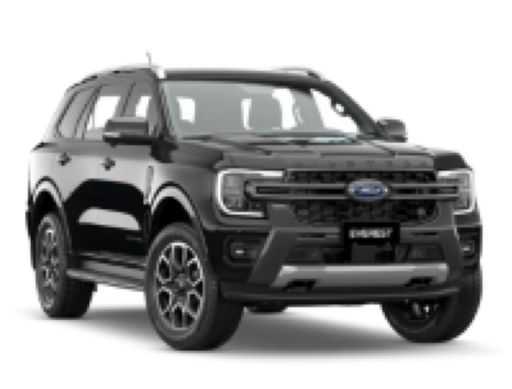

Target image size: (270, 480)


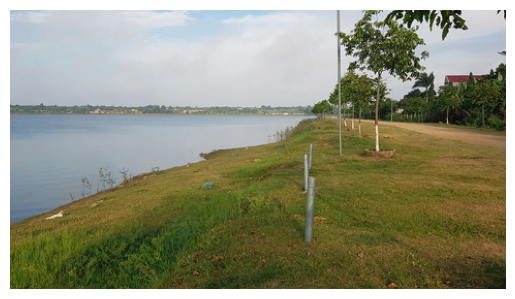

Mask size: (270, 480)


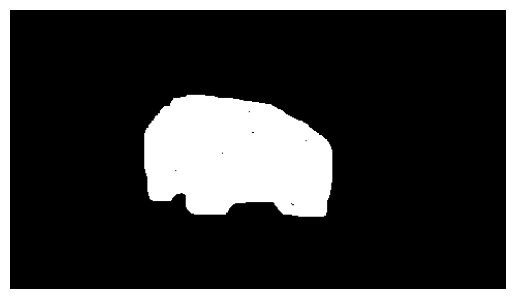

In [75]:
source = cv2.imread(os.path.join("./ED/car1.png")) 
target = cv2.imread(os.path.join("./ED/Eakarlake.png"))
mask = cv2.imread(os.path.join("./ED/target_mask.png"), cv2.IMREAD_GRAYSCALE) 
offset = (125, 67)
print('Source image size:', source.shape[:-1])
plt.imshow(source[:,:,::-1]) # this is a trick to display the image in here 
plt.axis('off')
plt.show()
print('Target image size:', target.shape[:-1])
plt.imshow(target[:,:,::-1])
plt.axis('off')
plt.show()
print('Mask size:', mask.shape)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()


Source image size: (270, 480)


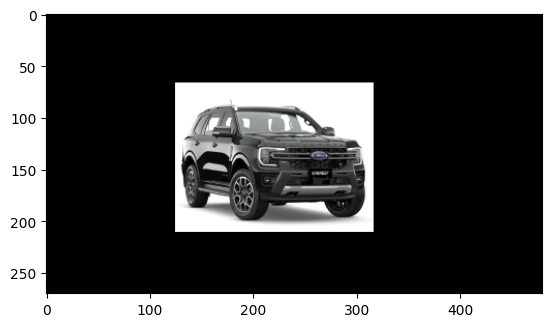

In [76]:
y_max, x_max = target.shape[:-1]
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min

M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
source = cv2.warpAffine(source, M, (x_range, y_range))

print('Source image size:', source.shape[:-1])
plt.imshow(source[:,:,::-1]) 
plt.show()
mask = mask[y_min:y_max, x_min:x_max]
mask[mask != 0] = 1

matrix_a = get_laplacian_matrix(y_range, x_range)
laplacian = matrix_a.tocsc()

for y in range(1, y_range - 1):
    for x in range(1, x_range - 1):
        if mask[y, x] == 0:
            k = x + y * x_range
            matrix_a[k, k] = 1
            matrix_a[k, k + 1] = 0
            matrix_a[k, k - 1] = 0
            matrix_a[k, k + x_range] = 0
            matrix_a[k, k - x_range] = 0
matrix_a = matrix_a.tocsc()

mask_flat = mask.flatten()    
for channel in range(source.shape[2]):
    source_flat = source[y_min:y_max, x_min:x_max, channel].flatten()
    target_flat = target[y_min:y_max, x_min:x_max, channel].flatten()        
    # \Delta f = div v = \Delta g       
    alpha = 1
    matrix_b = laplacian.dot(source_flat)*alpha

    # f = t
    matrix_b[mask_flat == 0] = target_flat[mask_flat == 0]
    
    x = spsolve(matrix_a, matrix_b)    
    x = x.reshape((y_range, x_range))
    x[x > 255] = 255
    x[x < 0] = 0
    x = x.astype('uint8')
    
    target[y_min:y_max, x_min:x_max, channel] = x



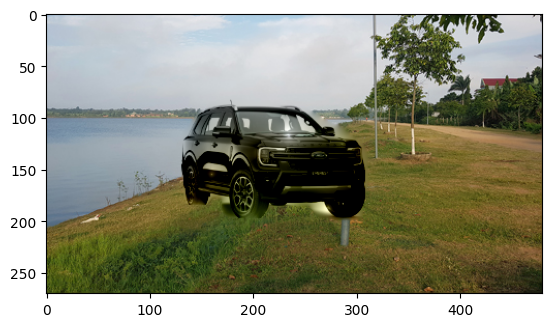

True

In [77]:
plt.imshow(target[:,:,::-1]) 
plt.show()

cv2.imwrite(os.path.join("possion1.png"), target)